<a href="https://colab.research.google.com/github/rreschke/temp-ciencia-de-dados-proj-1/blob/master/Projeto_S1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto de Data Science aplicado à dataset do Airbnb Rio
## Objetivo: criar um modelo que determine o preço do imóvel (considerando o brasileiro médio comum)

## **1 Bibliotecas**

In [ ]:
import pandas as pd # Manipulação de DataFrames e Series
import pathlib # Navegar entre pastas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import time
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### 1.1 Funções auxiliares

In [ ]:
def limites(coluna):
    """
    Cálculo de limites inferior e superior para detecção de outliers
    """
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude
    
def excluir_outliers(df, nome_coluna):
    """
    Exclusão de outliers de uma coluna de um DataFrame
    """
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df,  linhas_removidas

def diagrama_caixa(coluna, titulo, xlabel,fontsize_axis, fontsize_title):
    """
    Diagrama de caixa para visualização de outliers
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)
    fig.suptitle(titulo, fontsize=fontsize_title)
    ax1.set_xlabel(xlabel, fontsize=fontsize_axis)
    ax2.set_xlabel(xlabel, fontsize=fontsize_axis)
    ax1.set_title('Com outliers', fontsize=fontsize_title)
    ax2.set_title('Sem outliers', fontsize=fontsize_title)
    plt.show()
    
def histograma(coluna, titulo, xlabel, ylabel, fontsize_axis, fontsize_title):
    """
    Histograma para visualização de distribuição de dados
    """
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    sns.distplot(coluna, hist=True, ax=ax)
    ax.set_xlabel(xlabel, fontsize=fontsize_axis)
    ax.set_ylabel(ylabel, fontsize=fontsize_axis)
    ax.set_title(titulo, fontsize=fontsize_title)
    plt.show()

def grafico_barra(coluna, titulo, xlabel, ylabel, fontsize_axis, fontsize_title, fontsize_x, rotation_x=0):
    """
    Gráfico de barras para visualização de distribuição de dados
    """ 
    fig, ax = plt.subplots(1, 1, figsize=(8, 3))
    sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts(), ax=ax)
    ax.set_xlabel(xlabel, fontsize=fontsize_axis)
    ax.set_ylabel(ylabel, fontsize=fontsize_axis)
    ax.set_title(titulo, fontsize=fontsize_title)
    ax.tick_params(axis='x', rotation=rotation_x, labelsize=fontsize_x)
    qt_x = len(coluna.value_counts().index)
    if qt_x > 20:
        passo = int(np.ceil(qt_x / 20))
        ax.set_xticks(range(0, qt_x, passo))
    plt.show()

def agrupar_categorias(df, coluna, qtd_min_por_categoria):
    categorias = df[coluna].value_counts()
    categoarias_a_agrupar = []

    for categoria in categorias.index:
        if categorias[categoria] < qtd_min_por_categoria:
            categoarias_a_agrupar.append(categoria)

    for categoria in categoarias_a_agrupar:
        df.loc[df[coluna]==categoria, coluna] = 'Outros'

    return df

def treinar_modelos(X, y, modelos):
    t0 = time.time()
    X_train, X_test, y_train, y_test = train_test_split(X, y)
    metricas_modelos = []

    for nome_modelo, modelo in modelos.items():
        if nome_modelo == 'SupportVectorMachines':
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            modelo.fit(X_train_scaled, y_train)
            previsao = modelo.predict(X_test_scaled)
            metricas_modelos.append(metricas_modelo(nome_modelo, y_test, previsao))
        else:
            #treinar
            modelo.fit(X_train, y_train)
            #testar
            previsao = modelo.predict(X_test)
            metricas_modelos.append(metricas_modelo(nome_modelo, y_test, previsao))

    tf = time.time()

    print("Demorou", (round((tf-t0)/60, 2)), "minutos para treinar os modelos")

    return metricas_modelos

## **2 Importação das bases de dados**

### 2.1 Obtenção dos dados

In [ ]:
t_o = time.time()

try:
    df_airbnb_listagens = pd.read_csv("http://data.insideairbnb.com/brazil/rj/rio-de-janeiro/2023-03-28/data/listings.csv.gz")
except:
    #Busca o arquivo no repositório do GitHub
    try:
        df_airbnb_listagens = pd.read_csv("https://raw.githubusercontent.com/Ciencia-de-Dados-IMT/Projeto-I/main/listings.csv.gz")
    except:
        df_airbnb_listagens = pd.read_csv("listings.csv.gz")
  
t_f = time.time()

print("Demorou", round(t_f-t_o, 2), "segundos para importar os dados")

Demorou 3.99 segundos para importar os dados


### 2.2 Visualização de quais dados estão disponíveis

In [ ]:
print("Colunas disponíveis:")
for col in df_airbnb_listagens.columns:
    print(f'\t{col}')

Colunas disponíveis:
	id
	listing_url
	scrape_id
	last_scraped
	source
	name
	description
	neighborhood_overview
	picture_url
	host_id
	host_url
	host_name
	host_since
	host_location
	host_about
	host_response_time
	host_response_rate
	host_acceptance_rate
	host_is_superhost
	host_thumbnail_url
	host_picture_url
	host_neighbourhood
	host_listings_count
	host_total_listings_count
	host_verifications
	host_has_profile_pic
	host_identity_verified
	neighbourhood
	neighbourhood_cleansed
	neighbourhood_group_cleansed
	latitude
	longitude
	property_type
	room_type
	accommodates
	bathrooms
	bathrooms_text
	bedrooms
	beds
	amenities
	price
	minimum_nights
	maximum_nights
	minimum_minimum_nights
	maximum_minimum_nights
	minimum_maximum_nights
	maximum_maximum_nights
	minimum_nights_avg_ntm
	maximum_nights_avg_ntm
	calendar_updated
	has_availability
	availability_30
	availability_60
	availability_90
	availability_365
	calendar_last_scraped
	number_of_reviews
	number_of_reviews_ltm
	number_of_revi

## **3 Tratar os Dados (Análise Qualitativa)**

1.   Excluir informações não relevantes  
2.   Excluir colunas repetidas ou extremamente parecidadas com outra
3.   Excluir colunas preenchidas com texto livre
4.   Excluir colunas com todos os valores iguais


### 3.1 Excluir informações não relevantes

Para isso, vamos criar um arquivo em excel com os 100 primeiros registros e fazer uma análise qualitativa, olhando as colunas e identificando quais são desnecessárias

In [ ]:
df_airbnb_listagens.head(100).to_csv('primeiros_registros.csv', sep=';')

Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima (item 3), ficamos com as seguintes colunas:




In [ ]:
# colunas armazena a lista com as colunas que restarão
colunas = ['host_response_time', 'host_response_rate', 
           'host_acceptance_rate', 'host_is_superhost', 
           'neighbourhood_cleansed', 'latitude', 
           'longitude', 'property_type', 
           'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 
           'price', 'minimum_nights', 'availability_365', 'number_of_reviews', 
           'review_scores_rating', 'instant_bookable', 
           'calculated_host_listings_count']


df_airbnb_listagens = df_airbnb_listagens.loc[:, colunas]
print(f'Dimensões do DataFrame: {df_airbnb_listagens.shape}')

Dimensões do DataFrame: (30476, 20)


### 3.2 Tratar valores vazios

In [ ]:
# Mostra a quantidade valores vazios por coluna
print(df_airbnb_listagens.isnull().sum()) 

host_response_time                4695
host_response_rate                4695
host_acceptance_rate              3733
host_is_superhost                    7
neighbourhood_cleansed               0
latitude                             0
longitude                            0
property_type                        0
room_type                            0
accommodates                         0
bathrooms_text                      41
bedrooms                          1305
beds                               218
price                                0
minimum_nights                       0
availability_365                     0
number_of_reviews                    0
review_scores_rating              7504
instant_bookable                     0
calculated_host_listings_count       0
dtype: int64


Se houver mais de 7.500 linhas (Aproximadamente, 1/4 do total de linhas) vazias na coluna, exclui-se a coluna. Pode se tratar de um dado inconsistente.


In [ ]:
for coluna in df_airbnb_listagens:
    if df_airbnb_listagens[coluna].isnull().sum() > 7500:
        df_airbnb_listagens = df_airbnb_listagens.drop(coluna, axis=1)

print("Colunas removidas:")
for col in colunas:
    if col not in df_airbnb_listagens.columns:
        print(f'\t{col}')

Colunas removidas:
	review_scores_rating


Excluindo linhas com valores vazios para qualquer coluna

In [ ]:
nlinhas_i = df_airbnb_listagens.shape[0]
df_airbnb_listagens = df_airbnb_listagens.dropna()
nlinhas_f = df_airbnb_listagens.shape[0]

print(f'Número de linhas removidas: {nlinhas_i - nlinhas_f}')
print(f'Dimensões do DataFrame: {df_airbnb_listagens.shape}')

Número de linhas removidas: 6781
Dimensões do DataFrame: (23695, 19)


### 3.3 Verificar Tipos de Dados em cada coluna
- Precisamos fazer isso porque às vezes o Python está lendo como texto alguma coluna que deveria ser um número, então precisamos corrigir

In [ ]:
print(df_airbnb_listagens.dtypes)
print('-'*60)
print(df_airbnb_listagens.iloc[0])

host_response_time                 object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                  object
neighbourhood_cleansed             object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
bathrooms_text                     object
bedrooms                          float64
beds                              float64
price                              object
minimum_nights                      int64
availability_365                    int64
number_of_reviews                   int64
instant_bookable                   object
calculated_host_listings_count      int64
dtype: object
------------------------------------------------------------
host_response_time                 within an hour
host_response_rate                           100%
host_acceptance_rate       

Como o preço está identificado como objeto, devemos tratá-lo para transformar em float.

In [ ]:
#price
df_airbnb_listagens['price'] = df_airbnb_listagens['price'].str.replace('$', '')
df_airbnb_listagens['price'] = df_airbnb_listagens['price'].str.replace(',', '')
df_airbnb_listagens['price'] = df_airbnb_listagens['price'].astype(np.float64, copy=False)
print(df_airbnb_listagens.dtypes)

host_response_time                 object
host_response_rate                 object
host_acceptance_rate               object
host_is_superhost                  object
neighbourhood_cleansed             object
latitude                          float64
longitude                         float64
property_type                      object
room_type                          object
accommodates                        int64
bathrooms_text                     object
bedrooms                          float64
beds                              float64
price                             float64
minimum_nights                      int64
availability_365                    int64
number_of_reviews                   int64
instant_bookable                   object
calculated_host_listings_count      int64
dtype: object


## **4 Análise Exploratória e Tratar Outliers**


- Vamos basicamente olhar feature por feature para:
    1. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    2. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    3. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

Correlação negativa: grandezas inversamente proporcionais
Correlação positiva: grandezas diretamente proporcionais

### 4.1 Tratamento de valores numéricos

#### 4.1.1 price

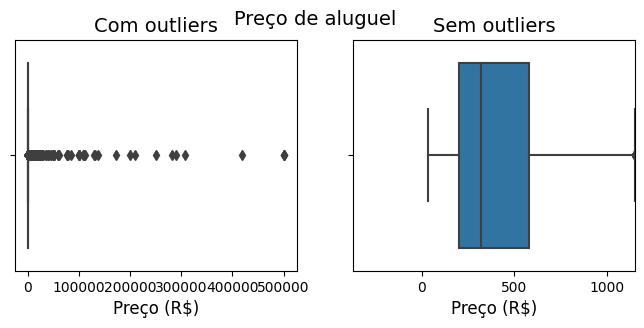

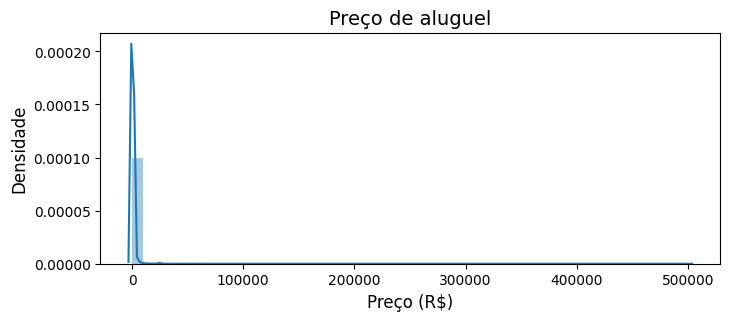

In [ ]:
diagrama_caixa(df_airbnb_listagens['price'], 'Preço de aluguel', 'Preço (R$)', 12, 14)
histograma(df_airbnb_listagens['price'], 'Preço de aluguel', 'Preço (R$)', 'Densidade', 12, 14)

Como estamos construindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de apartamentos de altíssimo luxo, que não é o nosso objetivo principal. Por isso, podemos excluir esses outliers.

In [ ]:
df_airbnb_listagens, linhas_removidas = excluir_outliers(df_airbnb_listagens, 'price')
print('{} linhas removidas'.format(linhas_removidas))

2152 linhas removidas


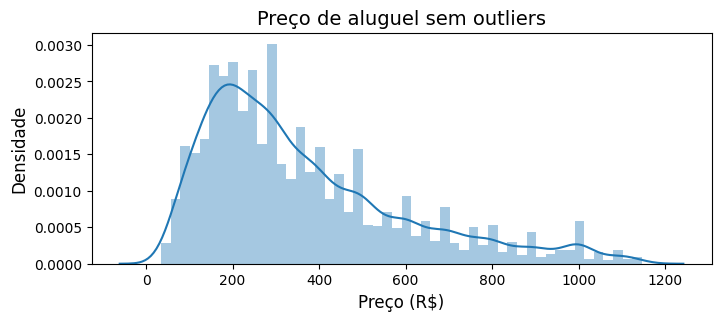

In [ ]:
histograma(df_airbnb_listagens['price'], 'Preço de aluguel sem outliers', 'Preço (R$)', 'Densidade', 12, 14)

#### 4.1.2 calculated_host_listings_count

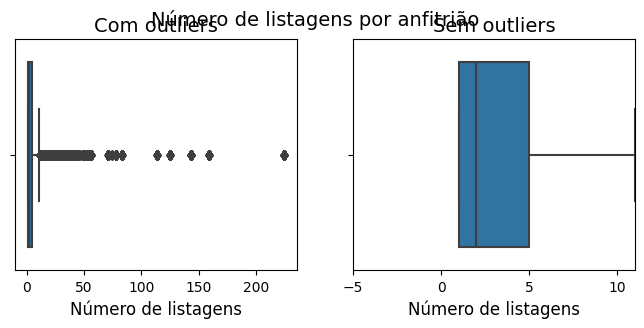

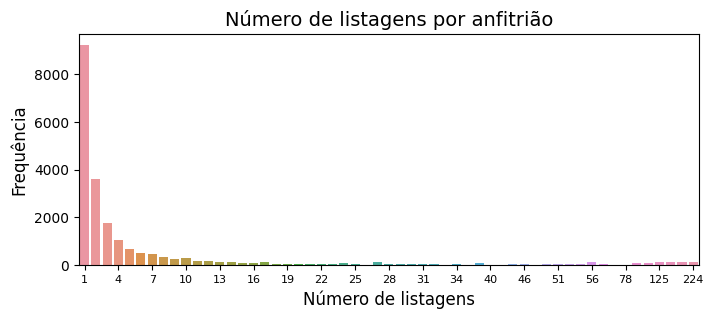

In [ ]:
diagrama_caixa(df_airbnb_listagens['calculated_host_listings_count'], 'Número de listagens por anfitrião', 'Número de listagens', 12, 14)
grafico_barra(df_airbnb_listagens['calculated_host_listings_count'], 'Número de listagens por anfitrião', 'Número de listagens', 'Frequência', 12, 14, 8)

Podemos excluir os outliers, porque para o objetivo do nosso projeto hosts com mais de 12 imóveis no airbnb não é o público alvo do objetivo (talvez sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [ ]:
df_airbnb_listagens, linhas_removidas = excluir_outliers(df_airbnb_listagens, 'calculated_host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

3165 linhas removidas


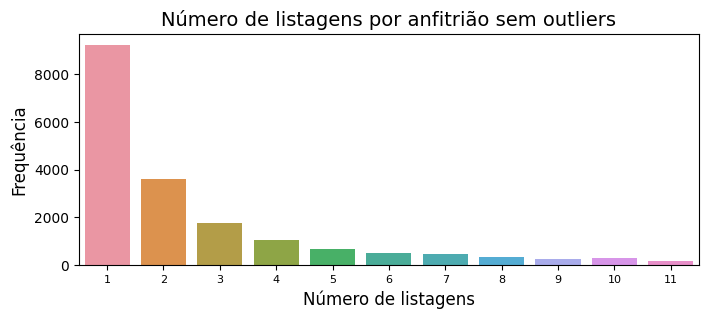

In [ ]:
grafico_barra(df_airbnb_listagens['calculated_host_listings_count'], 'Número de listagens por anfitrião sem outliers', 'Número de listagens', 'Frequência', 12, 14, 8)

#### 4.1.3 minimum_nights

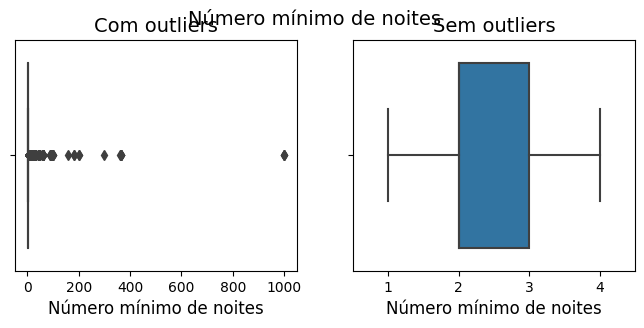

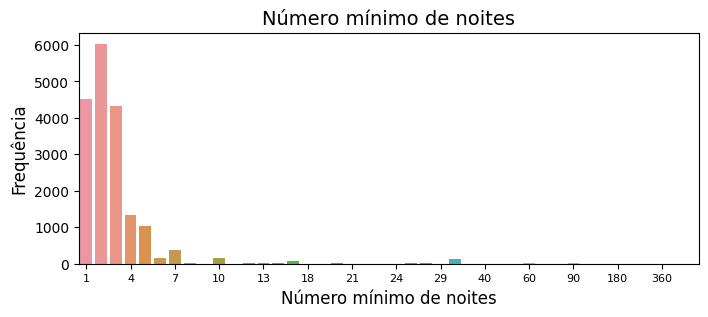

In [ ]:
diagrama_caixa(df_airbnb_listagens['minimum_nights'], 'Número mínimo de noites', 'Número mínimo de noites', 12, 14)
grafico_barra(df_airbnb_listagens['minimum_nights'], 'Número mínimo de noites', 'Número mínimo de noites', 'Frequência', 12, 14, 8)

- Aqui temos um motivo talvez até mais forte para excluir esses apartamentos da análise.

- Estamos querendo dados de apartamentos comuns como uma pessoa comum gostaria de disponibilizar. No caso, apartamentos com mais de 8 noites como o "mínimo de noites" podem ser apartamentos de temporada ou ainda apartamentos para morar, em que o host exige pelo menos 1 mês no apartamento.

- Por isso, vamos excluir os outliers dessa coluna

In [ ]:
df_airbnb_listagens, linhas_removidas = excluir_outliers(df_airbnb_listagens, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

2142 linhas removidas


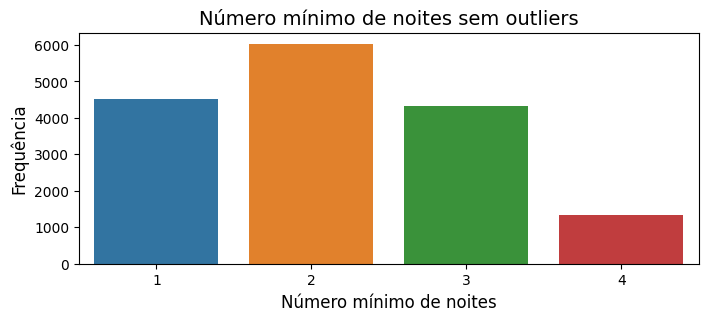

In [ ]:
grafico_barra(df_airbnb_listagens['minimum_nights'], 'Número mínimo de noites sem outliers', 'Número mínimo de noites', 'Frequência', 12, 14, 10)

#### 4.1.4 number_of_reviews

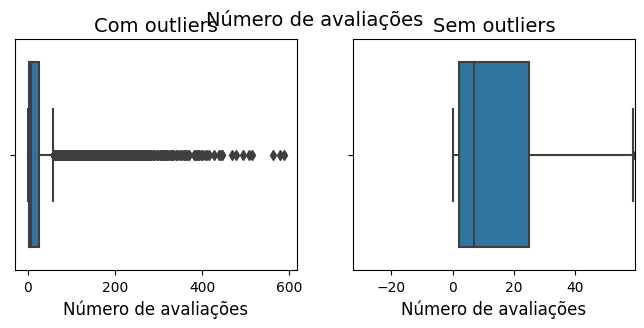

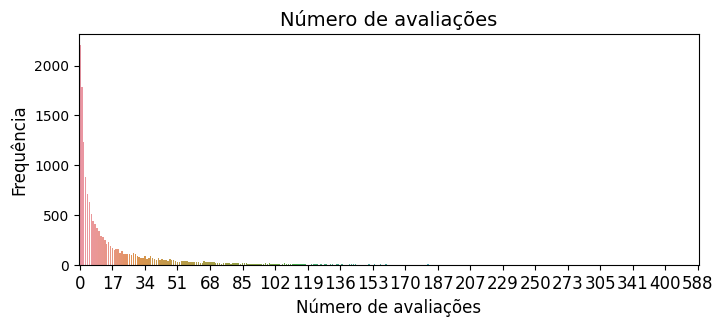

In [ ]:
diagrama_caixa(df_airbnb_listagens['number_of_reviews'], 'Número de avaliações', 'Número de avaliações', 12, 14)
grafico_barra(df_airbnb_listagens['number_of_reviews'], 'Número de avaliações', 'Número de avaliações', 'Frequência', 12, 14, 12)

- Aqui poderíamos tomar algumas decisões diferentes. Vamos uma decisão baseado na análise pessoal de tirar essa característica da análise, por alguns motivos:

    1. Se excluirmos os outliers, vamos excluir as pessoas que tem a maior quantidade de reviews (o que normalmente são os hosts que têm mais aluguel). Isso pode impactar muito negativamente o nosso modelo
    2. Pensando no nosso objetivo, se temos um imóvel parado e queremos colocar nosso imóvel no airbnb, é claro que eu não teremos review nenhuma inicialmente. Então talvez tirar essa característica da análise pode na verdade acabar ajudando.

In [ ]:
df_airbnb_listagens = df_airbnb_listagens.drop('number_of_reviews', axis=1)

#### 4.1.5 accommodates

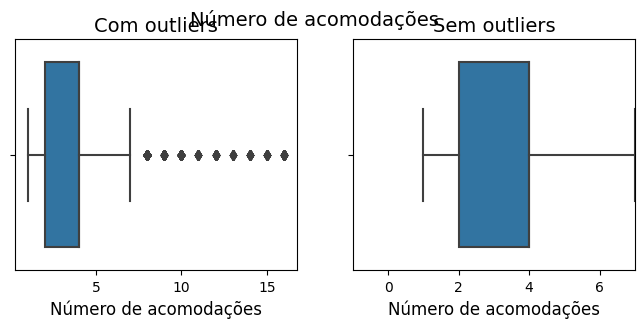

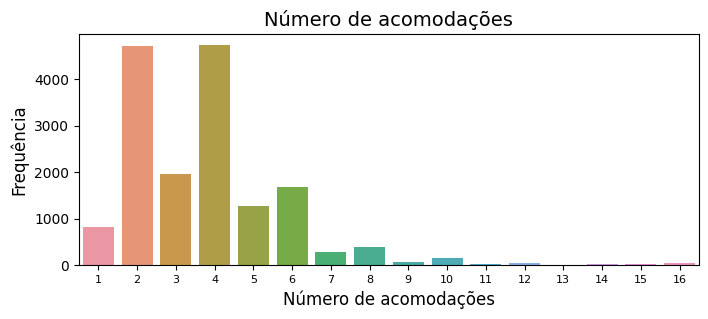

In [ ]:
diagrama_caixa(df_airbnb_listagens['accommodates'], 'Número de acomodações', 'Número de acomodações', 12, 14)
grafico_barra(df_airbnb_listagens['accommodates'], 'Número de acomodações', 'Número de acomodações', 'Frequência', 12, 14, 8)

Pelo mesmo motivo do "calculated_host_listings_count" vamos excluir os outliers dessa coluna porque apartamentos que acomodam mais de 9 pessoas não são o nosso foco, nosso objetivo aqui é para imóveis comuns.

Caso quiséssemos incluir apartamentos de alto padrão a poderiamos manter essa variável ou então construir um modelo só focado em imóvei com mais de 9 hóspedes

In [ ]:
df_airbnb_listagens, linhas_removidas = excluir_outliers(df_airbnb_listagens, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

774 linhas removidas


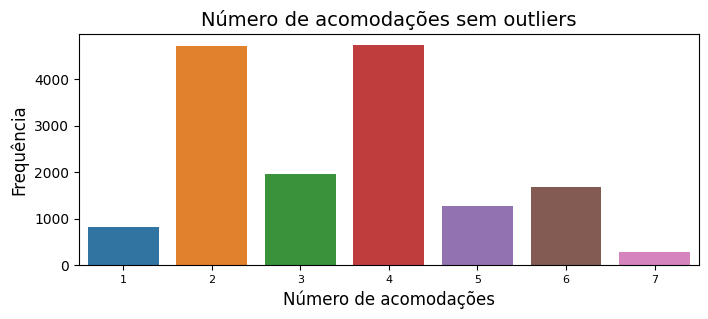

In [ ]:
grafico_barra(df_airbnb_listagens['accommodates'], 'Número de acomodações sem outliers', 'Número de acomodações', 'Frequência', 12, 14, 8)

### 4.2 Tratamento de Colunas de Valores de Texto

#### 4.2.1 bathrooms_text

In [ ]:
print(df_airbnb_listagens['bathrooms_text'].value_counts())
print(len(df_airbnb_listagens['bathrooms_text'].value_counts()))

bathrooms_text
1 bath               7106
2 baths              2726
1 shared bath        1646
1 private bath       1295
1.5 baths             888
3 baths               473
2.5 baths             391
2 shared baths        321
1.5 shared baths      315
3.5 baths              71
3 shared baths         53
2.5 shared baths       48
4 baths                39
Shared half-bath       12
4 shared baths         12
3.5 shared baths       11
4.5 baths               9
5 baths                 8
0 baths                 7
0 shared baths          7
5 shared baths          5
6 shared baths          4
Half-bath               3
6.5 shared baths        2
7 shared baths          2
4.5 shared baths        2
8 baths                 1
5.5 baths               1
16 baths                1
8 shared baths          1
Private half-bath       1
7 baths                 1
Name: count, dtype: int64
32


Vamos tratar os dados manualmente, dado que não são muitos valores

In [ ]:
df_airbnb_listagens['bathrooms_text'].unique()

array(['1 bath', '2 baths', '1.5 baths', '2.5 baths', '1 shared bath',
       '1 private bath', '3 baths', '1.5 shared baths', '5 shared baths',
       '2 shared baths', '0 shared baths', '5 baths', '2.5 shared baths',
       'Shared half-bath', '3.5 baths', '3 shared baths', '4 baths',
       '3.5 shared baths', '4.5 baths', '8 baths', '6.5 shared baths',
       '5.5 baths', '0 baths', '7 shared baths', '4 shared baths',
       '6 shared baths', '16 baths', 'Half-bath', '4.5 shared baths',
       '8 shared baths', 'Private half-bath', '7 baths'], dtype=object)

In [ ]:
mapa_num_banheiros = {
    '1 bath': 1,
    '2 baths': 2, 
    '1.5 baths': 2, 
    '2.5 baths': 3, 
    '1 shared bath': 1,
    '1 private bath': 1, 
    '3 baths': 3, 
    '1.5 shared baths': 2, 
    '5 shared baths': 5,
    '2 shared baths': 2, 
    '0 shared baths': 0, 
    '5 baths': 5, 
    '2.5 shared baths': 3,
    'Shared half-bath': 1, 
    '3.5 baths': 4, 
    '3 shared baths': 3, 
    '4 baths': 4,
    '3.5 shared baths': 4, 
    '4.5 baths': 5, 
    '8 baths': 8, 
    '6.5 shared baths': 7,
    '5.5 baths': 6, 
    '0 baths': 0, 
    '7 shared baths': 7, 
    '4 shared baths': 4,
    '6 shared baths': 6, 
    '16 baths': 16, 
    'Half-bath': 1, 
    '4.5 shared baths': 5,
    '8 shared baths': 8, 
    'Private half-bath': 1, 
    '7 baths': 7
}

In [ ]:
for mapa in mapa_num_banheiros:
    df_airbnb_listagens.loc[df_airbnb_listagens['bathrooms_text'] == mapa, 'bathrooms_text'] = mapa_num_banheiros[mapa]

df_airbnb_listagens = df_airbnb_listagens.rename(columns={'bathrooms_text': 'bathrooms'})

Agora temos valores inteiros definindo a quantidade de banheiros do local

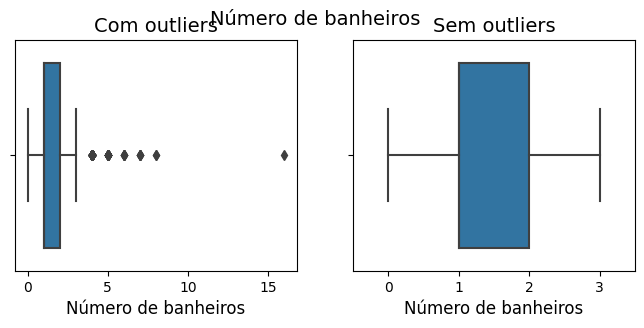

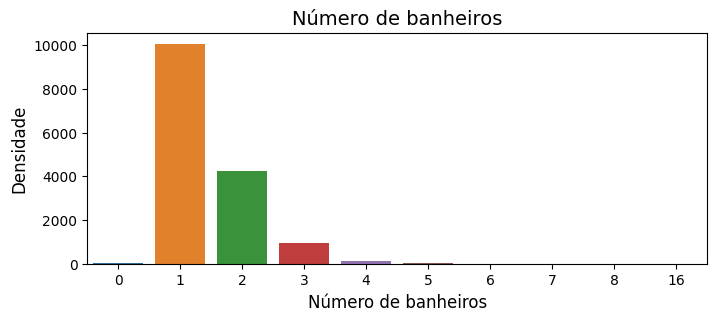

In [ ]:
diagrama_caixa(df_airbnb_listagens['bathrooms'], 'Número de banheiros', 'Número de banheiros', 12, 14)
grafico_barra(df_airbnb_listagens['bathrooms'], 'Número de banheiros', 'Número de banheiros', 'Densidade', 12, 14, 10)

Como casas com mais de 3 banheiros já são consideradas como de luxo - categoria fora do nosso escopo - iremos excluir os outliers

In [ ]:
df_airbnb_listagens, linhas_removidas = excluir_outliers(df_airbnb_listagens, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

170 linhas removidas


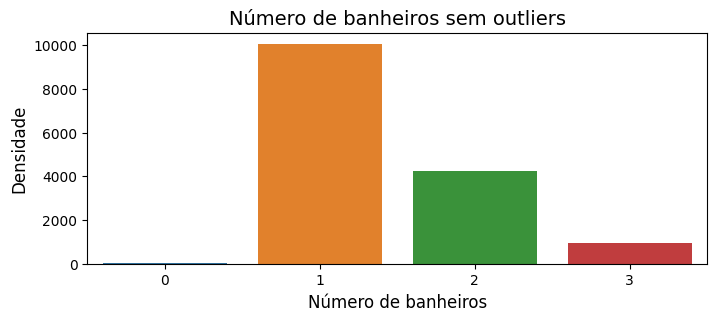

In [ ]:
grafico_barra(df_airbnb_listagens['bathrooms'], 'Número de banheiros sem outliers', 'Número de banheiros', 'Densidade', 12, 14, 10)

#### 4.2.2 property_type

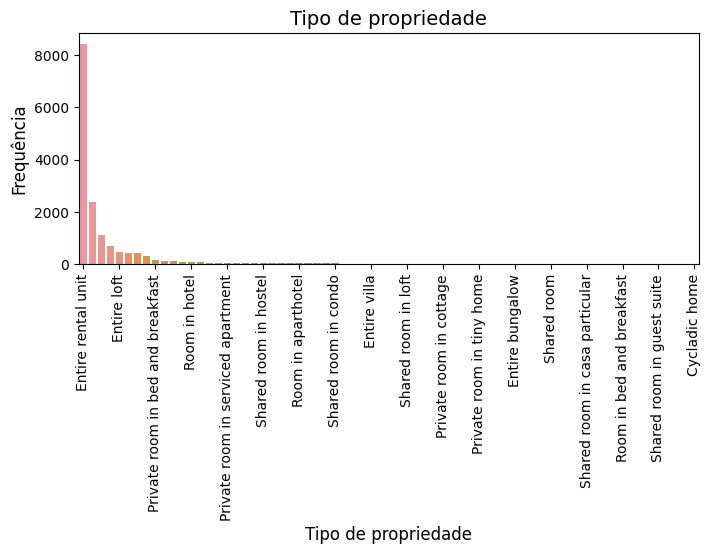

In [ ]:
grafico_barra(df_airbnb_listagens['property_type'], 'Tipo de propriedade', 'Tipo de propriedade', 'Frequência', 12, 14, 10, 90)

Aqui a nossa ação não é "excluir outliers", mas sim agrupar valores que são muito pequenos.

Todos os tipos de propriedade que têm menos de 500 propriedades na base de dados, vamos agrupar em um grupo chamado "outros". Isso vai facilitar o nosso modelo

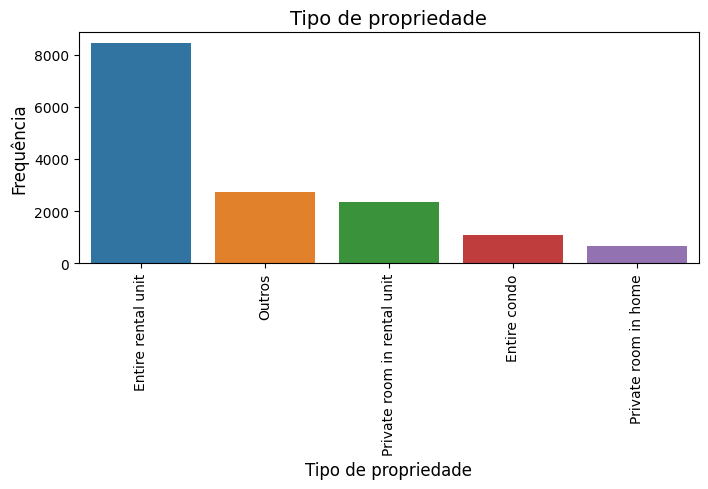

In [ ]:
df_airbnb_listagens = agrupar_categorias(df_airbnb_listagens, 'property_type', 500)

grafico_barra(df_airbnb_listagens['property_type'], 'Tipo de propriedade', 'Tipo de propriedade', 'Frequência', 12, 14, 10, 90)

#### 4.2.3 room_type

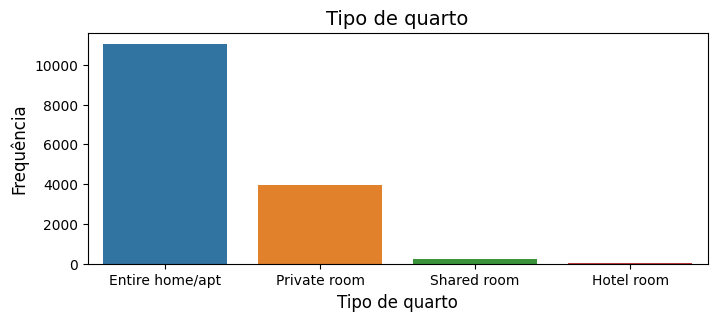

In [ ]:
grafico_barra(df_airbnb_listagens['room_type'], 'Tipo de quarto', 'Tipo de quarto', 'Frequência', 12, 14, 10)

Em tipo de quarto, não precisamos fazer nada, já parece estar bem distribuído

#### 4.2.4 host_response_time

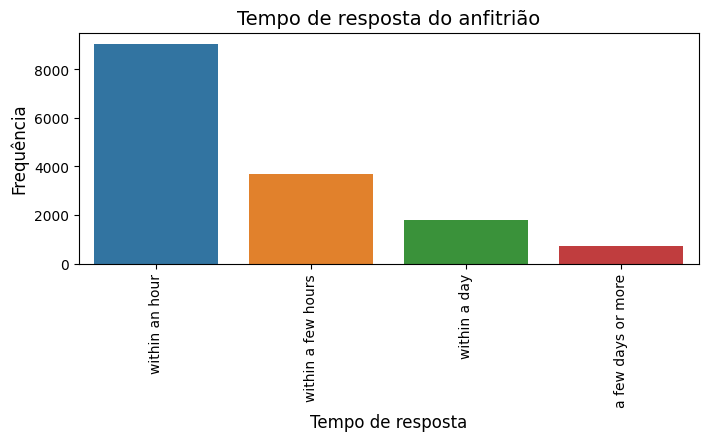

In [ ]:
grafico_barra(df_airbnb_listagens['host_response_time'], 'Tempo de resposta do anfitrião', 'Tempo de resposta', 'Frequência', 12, 14, 10, 90)

O tempo de resposta do host é dividido em 4 categorias. Como não são muitas, não precisa haver agrupamento

#### 4.2.5 neighbourhood_cleansed

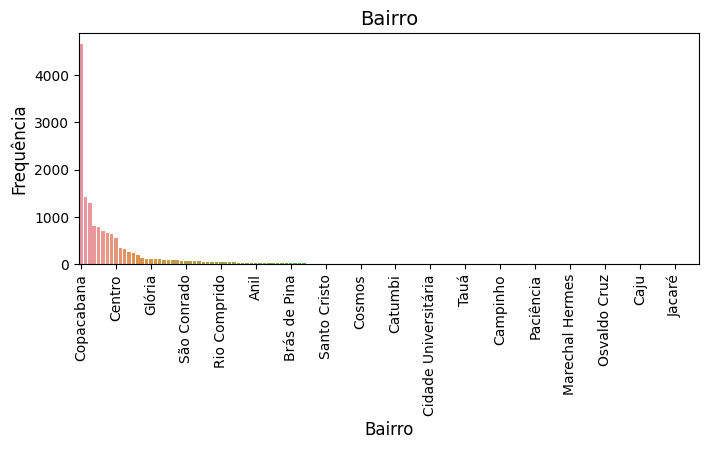

In [ ]:
grafico_barra(df_airbnb_listagens['neighbourhood_cleansed'], 'Bairro', 'Bairro', 'Frequência', 12, 14, 10, 90)

Como são muitas "Vizinhanças", conjuntos com quantidades inferiores a 250 serão agrupados em "Outros"

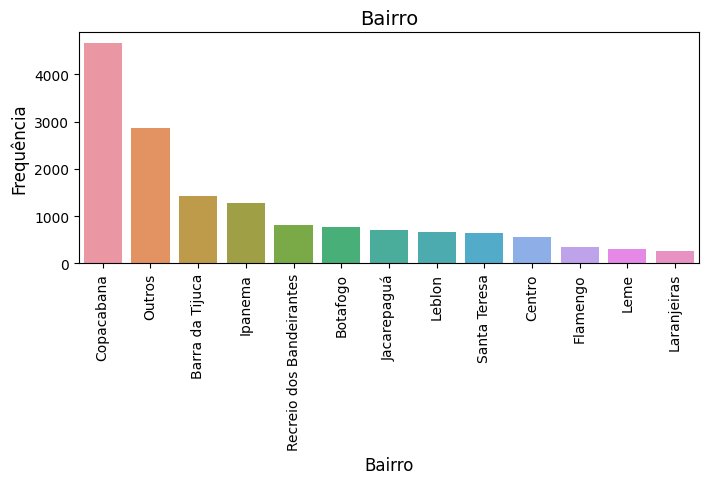

In [ ]:
df_airbnb_listagens = agrupar_categorias(df_airbnb_listagens, 'neighbourhood_cleansed', 250)

grafico_barra(df_airbnb_listagens['neighbourhood_cleansed'], 'Bairro', 'Bairro', 'Frequência', 12, 14, 10, 90)

#### 4.2.6 host_response_rate e host_acceptance_rate

Ambas as colunas finalizadas em __rate_ estão em porcentagem. É necessário trsnformá-las em float

In [ ]:
df_airbnb_listagens['host_response_rate'] = df_airbnb_listagens['host_response_rate'].str.replace('%', '')
df_airbnb_listagens['host_response_rate'] = df_airbnb_listagens['host_response_rate'].str.replace(',', '.')
df_airbnb_listagens['host_response_rate'] = df_airbnb_listagens['host_response_rate'].astype(np.float64, copy=False)
df_airbnb_listagens['host_response_rate'] = df_airbnb_listagens['host_response_rate'] / 100

In [ ]:
df_airbnb_listagens['host_acceptance_rate'] = df_airbnb_listagens['host_acceptance_rate'].str.replace('%', '')
df_airbnb_listagens['host_acceptance_rate'] = df_airbnb_listagens['host_acceptance_rate'].str.replace(',', '.')
df_airbnb_listagens['host_acceptance_rate'] = df_airbnb_listagens['host_acceptance_rate'].astype(np.float64, copy=False)
df_airbnb_listagens['host_acceptance_rate'] = df_airbnb_listagens['host_acceptance_rate'] / 100

### 4.3 Visualização da correlação entre as variáveis numéricas

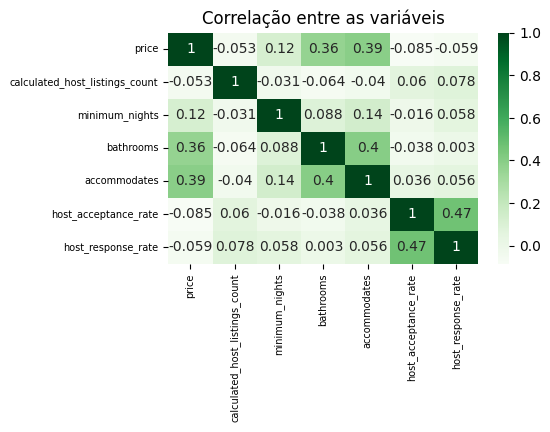

In [ ]:
# Mapa de calor ainda ajuda a confirmar se há duas colunas iguais visto que só pode haver 1 na diagonal principal da matriz (Teria algum 1 aleatório no mapa)

plt.figure(figsize=(5, 3))
dfcor = df_airbnb_listagens[['price', 'calculated_host_listings_count', 
                            'minimum_nights', 'bathrooms', 'accommodates', 
                            'host_acceptance_rate', 'host_response_rate']]

hmap = sns.heatmap(dfcor.corr(), annot=True, cmap='Greens')
hmap.set_title('Correlação entre as variáveis')
hmap.tick_params(axis="both", labelsize=7)
plt.show()

Podemos notar que não há correlações próximas a 1 (exceto na diagonal principal), o que demonstra qua não existem variáveis com o mesmo valor, porém nomes diferentes.<br>
Dessa forma, não precisamos excluir nenhuma coluna.

## **5 Encoding**


Precisamor Ajustar as features para facilitar as análises futuras (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

**Criar Variáveis Dummies (Transformar textos em números)**

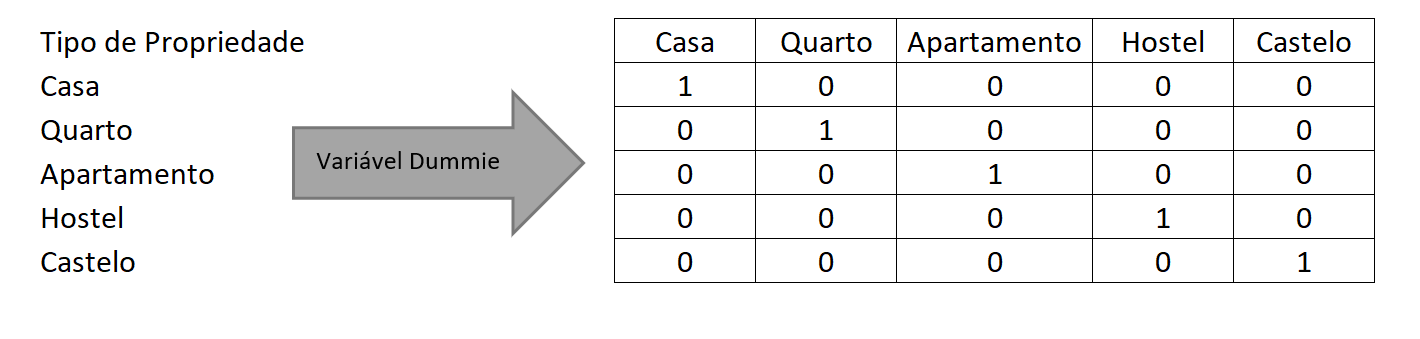

In [ ]:
# Variável Dummie
colunas_categorias = ['property_type', 'room_type','host_response_time', 'neighbourhood_cleansed']
base_airbnb_listagens_cod = df_airbnb_listagens.copy()
base_airbnb_listagens_cod = pd.get_dummies(data=base_airbnb_listagens_cod, columns=colunas_categorias)
display(base_airbnb_listagens_cod.head())

,host_response_rate,host_acceptance_rate,host_is_superhost,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,...,neighbourhood_cleansed_Copacabana,neighbourhood_cleansed_Flamengo,neighbourhood_cleansed_Ipanema,neighbourhood_cleansed_Jacarepaguá,neighbourhood_cleansed_Laranjeiras,neighbourhood_cleansed_Leblon,neighbourhood_cleansed_Leme,neighbourhood_cleansed_Outros,neighbourhood_cleansed_Recreio dos Bandeirantes,neighbourhood_cleansed_Santa Teresa
2,1.0,0.89,f,-22.96582,-43.17786,2,1,1.0,1.0,266.0,...,True,False,False,False,False,False,False,False,False,False
3,1.0,0.33,f,-22.98405,-43.20189,2,1,1.0,1.0,624.0,...,False,False,True,False,False,False,False,False,False,False
5,1.0,0.86,t,-22.96392,-43.17263,2,1,1.0,2.0,236.0,...,False,False,False,False,False,False,True,False,False,False
6,1.0,0.58,f,-22.97735,-43.19105,3,1,1.0,1.0,307.0,...,True,False,False,False,False,False,False,False,False,False
7,1.0,0.75,f,-23.00980,-43.37099,4,2,2.0,2.0,539.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Colunas verdadeiros e falsos -> 1 e 0
colunas_tf = ['host_is_superhost', 'instant_bookable']
for coluna in colunas_tf:
  base_airbnb_listagens_cod.loc[base_airbnb_listagens_cod[coluna]=='t', coluna] = 1
  base_airbnb_listagens_cod.loc[base_airbnb_listagens_cod[coluna]=='f', coluna] = 0
display(base_airbnb_listagens_cod.head())

,host_response_rate,host_acceptance_rate,host_is_superhost,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,...,neighbourhood_cleansed_Copacabana,neighbourhood_cleansed_Flamengo,neighbourhood_cleansed_Ipanema,neighbourhood_cleansed_Jacarepaguá,neighbourhood_cleansed_Laranjeiras,neighbourhood_cleansed_Leblon,neighbourhood_cleansed_Leme,neighbourhood_cleansed_Outros,neighbourhood_cleansed_Recreio dos Bandeirantes,neighbourhood_cleansed_Santa Teresa
2,1.0,0.89,0,-22.96582,-43.17786,2,1,1.0,1.0,266.0,...,True,False,False,False,False,False,False,False,False,False
3,1.0,0.33,0,-22.98405,-43.20189,2,1,1.0,1.0,624.0,...,False,False,True,False,False,False,False,False,False,False
5,1.0,0.86,1,-22.96392,-43.17263,2,1,1.0,2.0,236.0,...,False,False,False,False,False,False,True,False,False,False
6,1.0,0.58,0,-22.97735,-43.19105,3,1,1.0,1.0,307.0,...,True,False,False,False,False,False,False,False,False,False
7,1.0,0.75,0,-23.00980,-43.37099,4,2,2.0,2.0,539.0,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
print(base_airbnb_listagens_cod.dtypes)
print('-'*60)
print(base_airbnb_listagens_cod.iloc[0])

host_response_rate                                 float64
host_acceptance_rate                               float64
host_is_superhost                                   object
latitude                                           float64
longitude                                          float64
accommodates                                         int64
bathrooms                                           object
bedrooms                                           float64
beds                                               float64
price                                              float64
minimum_nights                                       int64
availability_365                                     int64
instant_bookable                                    object
calculated_host_listings_count                       int64
property_type_Entire condo                            bool
property_type_Entire rental unit                      bool
property_type_Outros                                  bo

## **6 Modelo de Previsão**

### 6.1 Métricas de Avaliação

* CC (Coeficiente de Correlação): Nos dirá o quão bem o nosso modelo consegue explicar o preço. Isso seria um ótimo parâmetro para ver o quão bom é nosso modelo <br>
-> Quanto mais próximo de 100%, melhor

* MSE (Erro Médio Quadrático): Vamos calcular também o Erro Quadrático Médio, que vai mostrar para gente o quanto o nosso modelo está errando. <br>
-> Quanto menor for o erro, melhor

* MAE (Erro Médio Absoluto): Possui a mesma finalidade do MSE. <br>
-> Quanto menor for o erro, melhor

In [ ]:
def metricas_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    MSE = mean_squared_error(y_teste, previsao)
    MAE = mean_absolute_error(y_teste, previsao)
    return {nome_modelo: {
                          'CC':round(r2, 2),
                          'MSE':round(MSE, 2),
                          'MAE':round(MAE, 2)
                        }
            }

### 6.2 Escolha dos Modelos 

Esses são alguns dos modelos que existem para fazer previsão de valores numéricos (o que chamamos de regressão). Estamos querendo calcular o preço, portanto, queremos prever um valor numérico.

1. Random Forest
2. Linear Regression
3. Extra Tree
4. DecisionTree
5. Support Vector Machines
6. Gradient Boosting

In [ ]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()
modelo_dt = DecisionTreeRegressor()
modelo_svm = SVR()
modelo_gb = GradientBoostingRegressor()

modelos = {'RandomForest': modelo_rf,
          'LinearRegression': modelo_lr,
          'ExtraTrees': modelo_et,
          'DecisionTree': modelo_dt,
          'SupportVectorMachines': modelo_svm,
          'GradientBoosting': modelo_gb,
          }

# Dados reais de preço que queremos obter com o modelo
y = base_airbnb_listagens_cod['price']

# Dados que serão usados para treinar o modelo
X = base_airbnb_listagens_cod.drop('price', axis=1)

Dentro do método `treinar_modelo` há a separação entre dados de teste e dados de validação.<br>
Essa separação é necessária para poder avaliar se o modelo foi capaz ou não de determinar os preços com precisão após seu treinamento

In [ ]:
metricas_modelos = treinar_modelos(X, y, modelos)

Demorou 0.3 minutos para treinar os modelos


### 6.3 Análise dos Modelos

Vamos visualizar os resultados obtidos por cada modelo:

In [ ]:
for metrica in metricas_modelos:
    for nome_modelo, valores in metrica.items():
        print(nome_modelo)
        for metrica, valor in valores.items():
            print(f'\t{metrica}: {valor}')

RandomForest
	R²: 0.43
	MSE: 27393.43
	MAE: 117.28
LinearRegression
	R²: 0.37
	MSE: 30333.41
	MAE: 126.63
ExtraTrees
	R²: 0.4
	MSE: 28737.79
	MAE: 118.84
DecisionTree
	R²: -0.09
	MSE: 52196.02
	MAE: 154.35
SupportVectorMachines
	R²: 0.19
	MSE: 38875.09
	MAE: 131.95
GradientBoosting
	R²: 0.43
	MSE: 27549.61
	MAE: 118.87


Os resultados obtidos não foram satisfatórios.<br>
Com o maior R² = 0.43, é possível afirmar que, embora hajam muitos dados na análise, não é possível precificar um imóvel com base neles com muita precisão.

## **7 Distribuição dos preços**

### 7.1 Visualização de Mapa das Propriedades e Seus Preços

Vamos criar um mapa que exibe nossa base de dados para ver como as propriedades estão distribuídas pela cidade e também identificar os locais de maior preço 

In [ ]:
centro_mapa = {'lat':df_airbnb_listagens.latitude.mean(), 'lon':df_airbnb_listagens.longitude.mean()}
mapa = px.density_mapbox(df_airbnb_listagens, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        mapbox_style='stamen-terrain',
                        title='Preço de aluguel por localização',
                        color_continuous_scale='viridis')
mapa.show()